# `x-ray-transmission-V3.ipynb`

Author: Niels Vanderloo with inspiration from a MATLAB script by Jacob Pearcy

This notebook is used to plot and fit transmission data taken from the [Proto XRD system](https://leia.psfc.mit.edu/wiki/index.php/PROTO-XRD).


## Prerequisites
- Uncommon Python packages:
  - `pip install mcareader`
  - `pip install xraydb` 

## Instructions for Taking Data

### Startup
- Switch on the power strip the spectrometer is plugged into
- Open DPPMCA app on laptop and connect spectrometer (should be automatic)
- Turn on x-ray machine with power button (lights up blue)
- Hold "x-ray off" button while adjusting voltage to -25 kV and current to 2.0 mA
- Press "x-ray on" button (door must be closed)
  - Verify that voltage and current are correct, if not adjust knobs
- Press shutter button (lights up red)

### Taking data
- Press "start aquisition" button on DPPMCA app
- Press "clear data and time" button on DPPMCA app (IMPORTANT - for time normalization)
- Run until ideally \~3million "total counts" (not input counts)
- Press "stop aquisition" button on DPPMCA app (must do BEFORE hitting the shutter off)
- Ctrl-S to save data as.
- Can clear data for next aquisition
  
### Shutdown
- Shutter off
- X-ray off
- Blue power button
- Turn off spectrometer power strip (important so spectrometer doesn't stay on and heat up all night)

### Doing a calibration
- Unscrew spectrometer from stand (can keep collimator in place)
- Place spectrometer leaning on plastic block with Am-241 source right in front of it
- Take spectrum until ideally \~1 million counts
- Note the three largest peaks (will be 13.81 keV, 17.7 keV, and 59.54 keV)
- For each peak
  - Click cursor on left hand side of the peak you want to measure
  - Press "U" key to move ROI to the right hand side of peak ("Y" to move left)
- Now click Calibrate
  - For each ROI click on ROI then prsss "Centroid" and enter corresponding peak energy then click "Add"
  - Press "Ok"

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import numpy as np

In [2]:
# Parameters to change

# for plot naming & title
SRF_id = 'A12' # SRF ID
window = 3 # 1,2,3

folder = "./SRF_230816/" # for saving figures 
fname_base = "./SRF_230816/baseline230816.mca" # raw baseline data
fname_filt = folder + SRF_id + "_window" + str(window) + "_230816.mca" # filtered data
# fname_filt = "./SRF_230816/A12_window2_230816.mca" # filtered data


# Crop range of data (usually between 5 and 20 keV)
emin = 6.5 # keV
emax = 20 # keV

# Material/element
material = 'Ta'

# Initial guess range of thickness (for fitting procedure)
lowGuess = 5 # micron
highGuess = 25 # micron

In [3]:
import mcareader as mca

raw = mca.Mca(fname_base)   # raw baseline data
filt = mca.Mca(fname_filt)   # data with filter/sample

# get exposure time lengths for normalization (in seconds)
raw_exp = float(raw.get_variable("REAL_TIME"))
filt_exp = float(filt.get_variable("REAL_TIME"))

# extract the calibration
calib = raw.get_calibration_function()
kevPerBins = calib(1)-calib(0) # keV per bin from calibration

# extract just the data
raw = raw.get_points()
filt = filt.get_points()

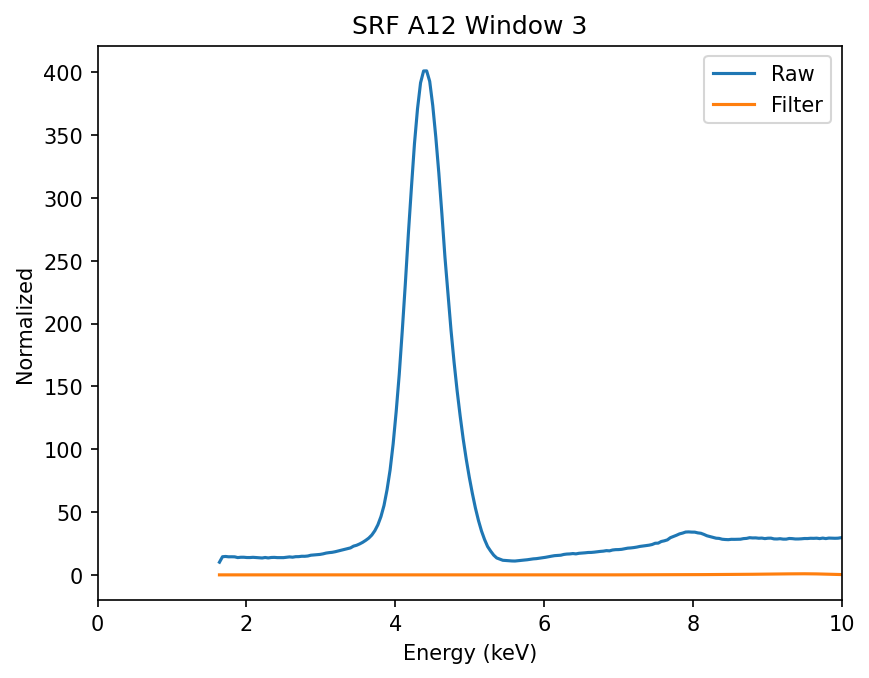

In [4]:
# normalize the data by the exposure time and plot 
rawNorm = raw[1]/raw_exp
filtNorm = filt[1]/filt_exp

plt.plot(raw[0],rawNorm, label="Raw")
plt.plot(filt[0],filtNorm, label="Filter")
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized")
plt.legend()
plt.title("SRF " + SRF_id + " Window " + str(window))
plt.xlim(0,10)
plt.show()

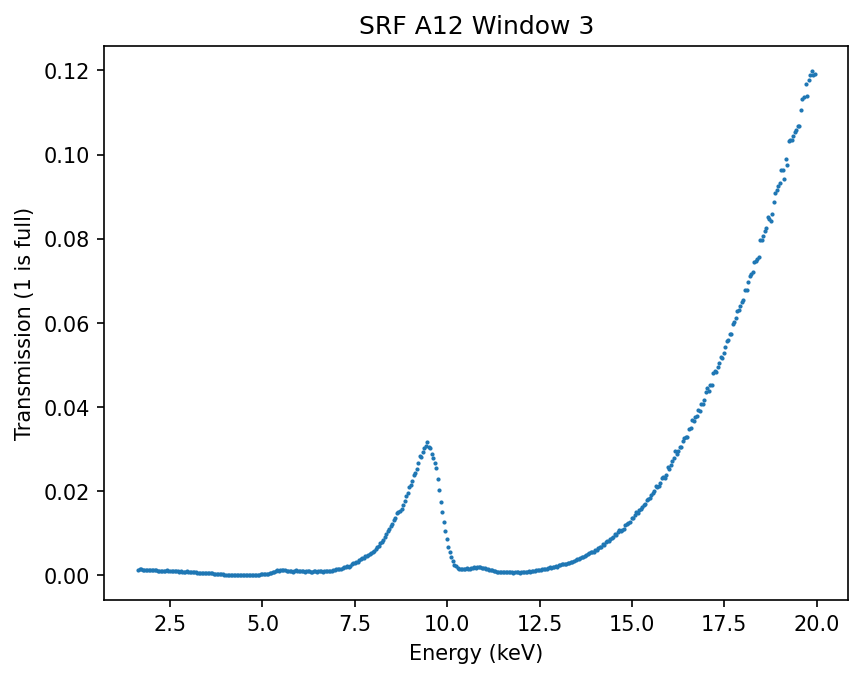

In [5]:
imin = np.argmin(np.abs(raw[0]-emin))
imax = np.argmin(np.abs(raw[0]-emax))

xAxis = raw[0][imin:imax]
raw_crop = raw[1][imin:imax]
filt_crop = filt[1][imin:imax]
rawNorm_crop = rawNorm[imin:imax]
filtNorm_crop = filtNorm[imin:imax]

plt.scatter(raw[0][0:imax], filtNorm[0:imax]/rawNorm[0:imax], s=1)
plt.xlabel("Energy (keV)")
plt.ylabel("Transmission (1 is full)")
plt.title("SRF " + SRF_id + " Window " + str(window))
plt.show() 

In [6]:
# fit a thickness to the data
import xraydb as xr
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter



def transmission(energy, thickness):
    if np.size(energy) == 1:
        return np.exp(-1*xr.material_mu(material, energy)*thickness) 
    else:
        return np.array([np.exp(-1*xr.material_mu(material, e)*thickness) for e in energy])

def convTransmission(energy, thickness):
    global gauss_FWHM
    global gauss_sigma
    gauss_FWHM = 0.530/kevPerBins # channels (from 530 eV FWHM @ 14.4 keV spectrometer specfication and 40.98 eV per channel from calibration https://www.amptek.com/internal-products/x-123-cdte-complete-x-ray-gamma-ray-spectrometer-with-cdte-detector)
    gauss_sigma = gauss_FWHM/2.355 
    return gaussian_filter(transmission(energy, thickness), sigma=gauss_sigma, mode='nearest')


# uncertainty analysis
f2 = np.square(filtNorm_crop/rawNorm_crop)
sigmaA = np.sqrt(filt_crop)/filt_exp
sigmaB = np.sqrt(raw_crop)/raw_exp
sigma = np.sqrt(f2*((sigmaA/filtNorm_crop)**2 + (sigmaB/rawNorm_crop)**2))

energies = xAxis*1e3 # convert to eV
# popt, pcov = curve_fit(transmission, energies, filtNorm_crop/rawNorm_crop, bounds=(lowGuess*1e-4,highGuess*1e-4),method='dogbox')

popt_conv, pcov_conv = curve_fit(convTransmission, energies, filtNorm_crop/rawNorm_crop, bounds=(lowGuess*1e-4,highGuess*1e-4),method='dogbox')



# perr = np.sqrt(np.diag(pcov)) # error for fitted thickness
perr_conv = np.sqrt(np.diag(pcov_conv)) # error for fitted thickness (convolution fit) 
print("Material fit to:", material)
# print("Fit Thickness (no convolution)= " + str(round(popt[0]*1e4, 3)) + "(" + str(round(perr[0]*1e4, 3)) + ") micron")
print("Fit Thickness (with gaussian conv.)= " + str(round(popt_conv[0]*1e4, 3)) + "(" + str(round(perr_conv[0]*1e4, 3)) + ") micron")

Material fit to: Ta
Fit Thickness (with gaussian conv.)= 19.594(0.013) micron


In [7]:
# fit_transmission = transmission(energies, *popt)
fit_transmission_conv = convTransmission(energies, *popt_conv)

In [8]:
# # Plot the data and fit (without convolution)

# plt.plot(xAxis, fit_transmission, label="Fit Thickness = " + str(round(popt[0]*1e4, 3)) + "(" + str(round(perr[0]*1e4, 3)) + ") $\mu$m", c='orange')
# plt.scatter(xAxis, filtNorm_crop/rawNorm_crop, label="Data", s=1)
# # 1 sigma error bars
# plt.fill_between(xAxis, fit_transmission-1*sigma, fit_transmission+1*sigma, alpha=0.3, label="$\pm \sigma$")
# # plt.ylim(0, 1.1)
# plt.title("SRF " + SRF_id + " Window " + str(window))
# plt.xlabel("Energy (keV)")
# plt.ylabel("Transmission (1 is full)")
# plt.legend()
# plt.show()

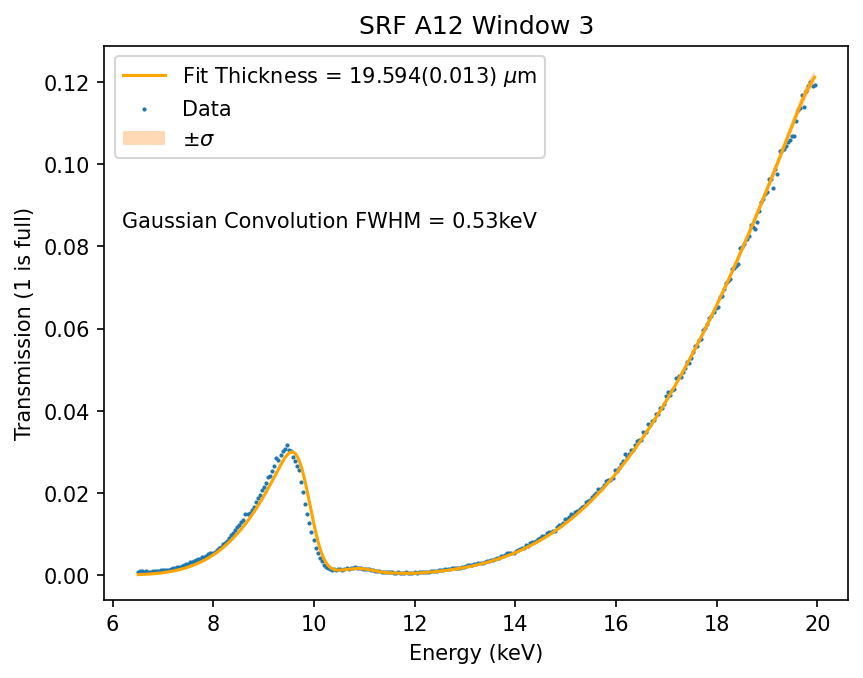

In [9]:
# Plot the data and fit (with convolution)

plt.plot(xAxis, fit_transmission_conv, label="Fit Thickness = " + str(round(popt_conv[0]*1e4, 3)) + "(" + str(round(perr_conv[0]*1e4, 3)) + ") $\mu$m", c='orange')
plt.scatter(xAxis, filtNorm_crop/rawNorm_crop, label="Data", s=1)
plt.fill_between(xAxis, fit_transmission_conv-1*sigma, fit_transmission_conv+1*sigma, alpha=0.3, label="$\pm \sigma$")
# 1 sigma error bars
plt.title("SRF " + SRF_id + " Window " + str(window))
plt.annotate("Gaussian Convolution FWHM = " + str(round(gauss_FWHM*kevPerBins, 3)) + "keV", (min(xAxis)*0.95, max(fit_transmission_conv)*0.7), fontsize=10)
plt.xlabel("Energy (keV)")
plt.ylabel("Transmission (1 is full)")
plt.legend()
plt.savefig(folder + "SRF" + SRF_id + "_Window" + str(window) + "_fit.png", dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

## Additional Code
This code is not necessary for the fitting routine but is useful for plotting tabluated data from the xraydb package.

Transmission (x-ray db): 8.839292698878383e-05


Text(0.5, 1.0, 'Transmission for 890 micron Ti')

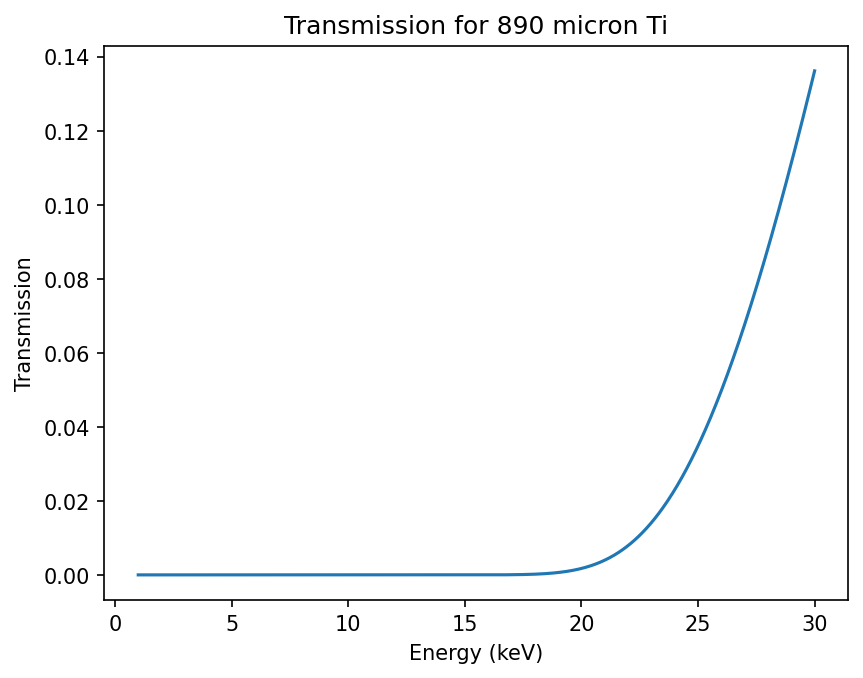

In [10]:
# Example code for calculating transmission fractions for a given material at a given energy
import xraydb as xr
import numpy as np

# list of materials for xraydb https://github.com/xraypy/XrayDB/blob/4c7ae7ec3278e24335bf487cef7a5b335fbb03d7/python/xraydb/materials.dat#L4

material = 'Ti' 
thickness = 890 # micron

# for particlar energy
energy = 17.48e3 # eV
transmission_xrdb = np.exp(-1*xr.material_mu(name = material, energy = energy)*thickness*1e-4)
print("Transmission (x-ray db):", transmission_xrdb)

# full spectrum
energy_range = np.linspace(1.0e3, 30.0e3, 1000)
transmission_range = np.exp(-1*xr.material_mu(material, energy_range)*thickness*1e-4)

import matplotlib.pyplot as plt
plt.plot(energy_range/1000, transmission_range)
plt.xlabel('Energy (keV)')
plt.ylabel('Transmission')
plt.title("Transmission for " + str(thickness) + " micron " + material)

<class 'numpy.ndarray'>


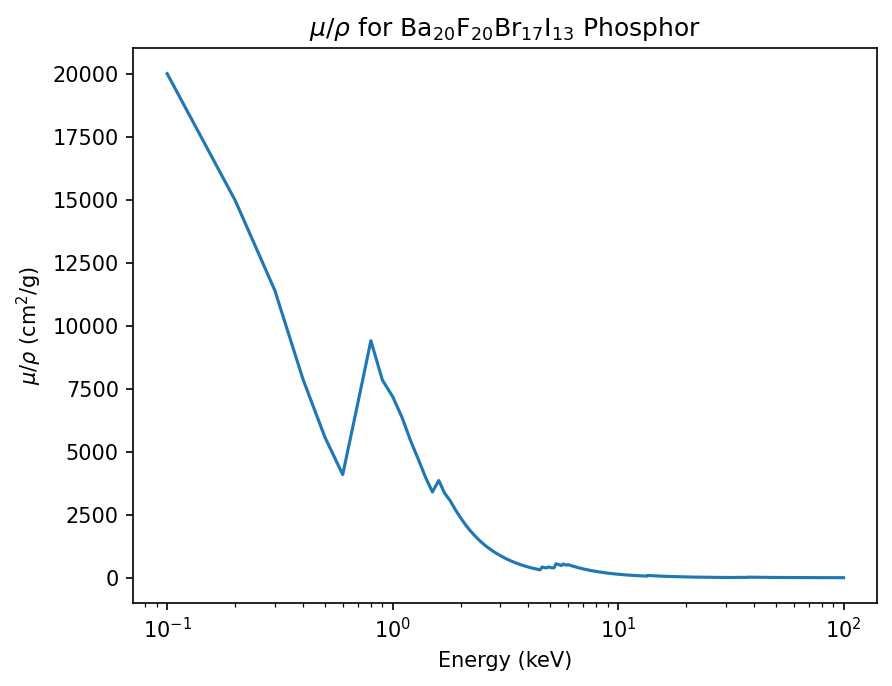

In [11]:
import xraydb as xr
import numpy as np
import matplotlib.pyplot as plt

material = 'Ba20F20Br17I13' # phosphor
thickness = 100 # micron

# can specify density (g/cm^3) (req for custom formula)
density = 3.1 

energyArr = np.linspace(0.1e3, 100e3, 999)
muArr = xr.material_mu(name = material, energy = energyArr, density = density)
print(type(muArr))
plt.plot(energyArr/1000, muArr/density)
plt.xlabel('Energy (keV)')
plt.ylabel(r'$\mu/ \rho$ (cm$^2$/g)')
plt.title(r"$\mu/ \rho$ for $\mathrm{Ba_{20}F_{20}Br_{17}I_{13}}$ Phosphor")
plt.xscale('log')
plt.show()

import pandas as pd
df = pd.DataFrame({'Energy (eV)': energyArr, 'Mu (1/cm)': muArr})
df.to_csv('Mu_Ba20F20Br17I13.csv', index=False)

In [12]:
import xraydb as xr
# get K-lines
element = 'Ag'

print("K-lines for", element)
for name, line in xr.xray_lines(element, 'K').items():
	print(name, line.energy/1000, "keV")

print("")
print("Edges for ", element)
for name, edge in xr.xray_edges(element).items():
	print(name, edge.energy/1000 , "keV")

K-lines for Ag
Ka3 21.708 keV
Ka2 21.99 keV
Ka1 22.163 keV
Kb3 24.9102 keV
Kb1 24.941 keV
Kb5 25.14 keV
Kb2 25.4503 keV
Kb4 25.51 keV

Edges for  Ag
K 25.514 keV
L1 3.806 keV
L2 3.524 keV
L3 3.351 keV
M1 0.719 keV
M2 0.6038 keV
M3 0.573 keV
M4 0.374 keV
M5 0.3683 keV
N1 0.097 keV
N2 0.0637 keV
N3 0.0583 keV
N4 0.004 keV
N5 0.004 keV
